In [1]:
import matplotlib.pyplot as plt
import numpy as np
from functions.CreateYarnGeneral import CreateYarn
from functions.CreateComposite import CreateComposite

In [2]:
# cualquier curva periodica puede ser describida por una serie de fourier




r = 5

trajs =[]  

fc1 = lambda x: np.sqrt(r**2 - x**2)
x12 = np.linspace(0,r,2000)
y12 = fc1(x12)

trajs.append( np.array([x12,y12, np.zeros_like(x12)]).T )

# =============================================================================

fc1 = lambda x: -np.sqrt(r**2 - (x-2*r)**2) + 2*r
x12 = np.linspace(r,2*r,2000)
y12 = fc1(x12)

trajs.append( np.array([x12,y12, np.zeros_like(x12)]).T )





(np.float64(-0.5), np.float64(10.5), np.float64(-0.5), np.float64(10.5))

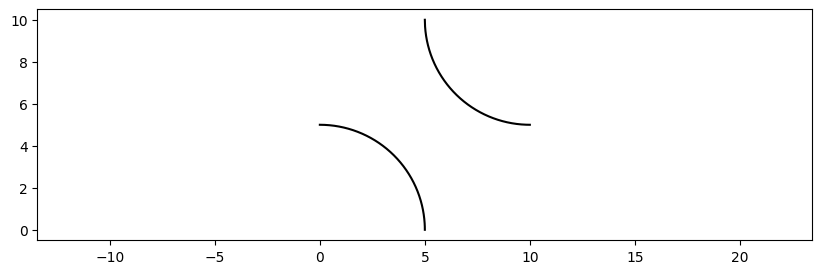

In [3]:

fig = plt.figure()
fig.set_size_inches(10, 3)
# compute fourier coefficients
for itraj in trajs:

    plt.plot(itraj[:,0], itraj[:,1], 'k')

plt.axis('equal')

In [4]:
itraj

array([[ 5.        , 10.        ,  0.        ],
       [ 5.00250125,  9.84186635,  0.        ],
       [ 5.0050025 ,  9.77639323,  0.        ],
       ...,
       [ 9.9949975 ,  5.0000025 ,  0.        ],
       [ 9.99749875,  5.00000063,  0.        ],
       [10.        ,  5.        ,  0.        ]])

In [5]:
radius = 1

first_vectors = [ [1, 0, 0] , [0, -1, 0] ]
last_vectors  = [ [0, -1, 0], [1,  0, 0] ]

for i,itraj in enumerate(trajs):

    file = "yarn_" + str(i) + ".brep"

    CreateYarn({"trajs": itraj, 
                "radius": radius, 
                "last_vector": last_vectors[i],
                "first_vector": first_vectors[i],
                "num_points": 20,
                "file": file})

In [6]:
# merge all the yarns

import gmsh

gmsh.initialize()
gmsh.model.add("composite")

for i in range(len(trajs)):
    gmsh.merge("yarn_" + str(i) + ".brep")

yarns = gmsh.model.getEntities(3)
dz = 3*radius
box = gmsh.model.occ.addBox(0  , 0  , -dz/2, 
                            2*r, 2*r, dz)
# cut 
gmsh.model.occ.synchronize()

gmsh.model.occ.cut([(3, box)], yarns, removeTool=False)
# 

# the box mesh must be periodic in the x direction, y direction and z direction

gmsh.model.occ.synchronize()


# Obtener las caras de la caja cortada
box_faces = gmsh.model.getBoundary([(3, box)], oriented=False, recursive=False)
box_faces = [face[1] for face in box_faces]
# give name 
gmsh.model.addPhysicalGroup(2, box_faces, 1)
gmsh.model.setPhysicalName(2, 1, "box")
# create all 3d volume

gmsh.model.occ.synchronize()

all_volumes = gmsh.model.getEntities(3)
# get mass center of each volume
volumes = []
for volume in all_volumes:
    volumes.append( (volume, gmsh.model.occ.getCenterOfMass(3, volume[1])) )
# sort by x
volumes = sorted(volumes, key=lambda x: x[1][0])
# 
names =[ "yarn_1","box", "yarn_2"] 

for i,volume in enumerate(volumes):
    gmsh.model.addPhysicalGroup(3, [volume[0][1]], i+1)
    gmsh.model.setPhysicalName(3, i+1, names[i])

surfaces = []
all_surfaces = gmsh.model.getEntities(2)

for surface in all_surfaces:
    surfaces.append( (surface, gmsh.model.occ.getCenterOfMass(2, surface[1])) )

surfaces = sorted(surfaces, key=lambda x: x[1][0])
##
# 2 first are name face_xmin 

ph_label = gmsh.model.addPhysicalGroup(2, [surfaces[0][0][1], surfaces[1][0][1]], -1)
gmsh.model.setPhysicalName(2, ph_label, "face_xmin")

# 2 last are name face_xmax
ph_label = gmsh.model.addPhysicalGroup(2, [surfaces[-1][0][1], surfaces[-2][0][1]], -1)
gmsh.model.setPhysicalName(2, ph_label, "face_xmax")
 
surfaces = sorted(surfaces, key=lambda x: x[1][1])
##
# 2 first are name face_ymin
ph_label = gmsh.model.addPhysicalGroup(2, [surfaces[0][0][1], surfaces[1][0][1]], -1)
gmsh.model.setPhysicalName(2, ph_label, "face_ymin")

# 2 last are name face_ymax
ph_label = gmsh.model.addPhysicalGroup(2, [surfaces[-1][0][1], surfaces[-2][0][1]], -1)

gmsh.model.setPhysicalName(2, ph_label, "face_ymax")

surfaces = sorted(surfaces, key=lambda x: x[1][2])

##

# 2 first are name face_zmin
ph_label = gmsh.model.addPhysicalGroup(2, [surfaces[0][0][1]], -1)
gmsh.model.setPhysicalName(2, ph_label, "face_zmin")

# 2 last are name face_zmax

ph_label = gmsh.model.addPhysicalGroup(2, [surfaces[-1][0][1]], -1)
gmsh.model.setPhysicalName(2, ph_label, "face_zmax")






Info    : Reading 'yarn_0.brep'...
Info    : Done reading 'yarn_0.brep'
Info    : Reading 'yarn_1.brep'...
Info    : Done reading 'yarn_1.brep'


In [7]:


gmsh.fltk.run()

# Identificar las caras periódicas
# Identificar las caras periódicas divididas

gmsh.model.occ.synchronize()


# mesh
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", radius*0.1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 4*radius)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 20)
gmsh.option.setNumber("Mesh.AngleSmoothNormals", 10)
gmsh.option.setNumber("Mesh.Smoothing", 10)	
gmsh.option.setNumber("Mesh.Algorithm", 2)

gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(3)
gmsh.model.mesh.setOrder(2)

gmsh.fltk.run()
# save in inp format
gmsh.write("composite_pbc_min.inp")




-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.7.2
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (

In [8]:
box_faces

[1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48]

In [9]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.7.2
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


In [10]:
from djccx.inp.inp import inp

Wine está instalado. Versión: wine-9.0
Wine is installed. Calculix will be run with windows binary


In [11]:
inp_f = inp("composite_pbc_min.inp")
inp_f.remove_by_type(2)
inp_f.remove_by_type(1)

inp_f.print("composite_no_solid_min.inp")

In [12]:
young = 2960
imaterial = inp_f.CreateElasticMaterial("elastic",young,0.0)
allelset  = inp_f.CreateElsetAll()

inp_f.CreateSolidSection(allelset,imaterial)
istep = inp_f.CreateStaticStep(nlgeom=True)


In [13]:
import os
join = os.path.join
inflation_folder = join("output")

if not os.path.exists(inflation_folder):
    os.makedirs(inflation_folder)

In [14]:
inp_f.remove_surface("SURFACE1")

In [15]:
frd = inp_f.run(inflation_folder)

Running Calculix at:  output
Output file:  /home/djoroya/projects/CITISENS/CITISENS_Composite/output/out.txt
Command:
 wine /home/djoroya/projects/CITISENS/CITISENS_Composite/.conda/lib/python3.13/site-packages/djccx/bin/ccx_dynamic.exe main > out.txt
Error reading cvf file

pid:  823853 

Calculix finished

